In [2]:
import matplotlib.animation as animation

from brian2 import *


### global parameters
defaultclock.dt = 30*ms


### simulation code
def run_sim(N, K, F, Delta, p1, p2, omega_0, tau, sigma, duration, random_seed=214040893):
    seed(random_seed)

    eqs = '''
    dTheta/dt = omega + K/N*coupling + F*sin(sigma*t - Theta + p): 1
    omega : Hz (constant) # intrinsic frequency
    coupling : 1
    p : 1
    '''

    oscillators = NeuronGroup(N, eqs, method='euler')
    oscillators.Theta = p1  # same initial phase angle
    oscillators.p = p1


    #CHANGE THIS TO ANOTHER VALUE
    lorentzian_omegas = omega_0 + Delta * np.tan(np.pi * (np.random.rand(N) - 0.5))
    oscillators.omega = lorentzian_omegas


    connections = Synapses(oscillators, oscillators,
                        'coupling_post = sin(Theta_pre - Theta_post) : 1 (summed)')
    connections.connect()  # all-to-all

    mon = StateMonitor(oscillators, 'Theta', record=True)

   # Variable to hold the current value of z
    z_values = []

    @network_operation()
    def update_p() :
        if defaultclock.t <= tau :
            oscillators.p = p1
        else :
            oscillators.p = p2
    
    @network_operation()
    def compute_z():
        # Calculate z(t) using the current phases
        z = np.mean(np.exp(1j * (oscillators.Theta[:] - (sigma * defaultclock.t) - p2)))
        if defaultclock.t > tau:
            z_values.append(z)

    net = Network(oscillators, connections, mon, compute_z, update_p)
    net.run(tau + duration)

    return z_values
        

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


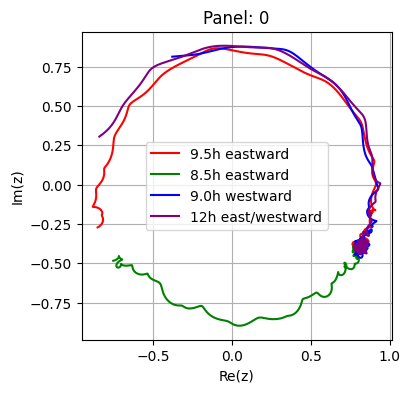

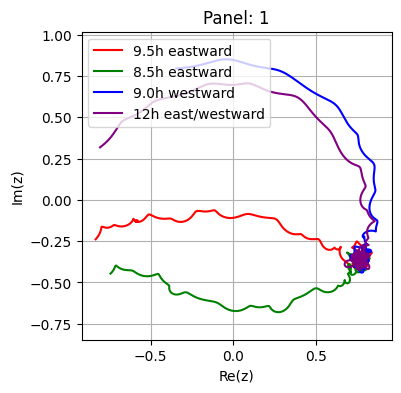

In [3]:
initial_values = [[10.0, 3.5, 1.4], [4.5, 3.5, 1.4]]
sigma = 2*pi/(24)*Hz
Delta = sigma
for count, arr in enumerate(initial_values): 
    K = arr[0] * Delta      # Coupling strength
    F = arr[1] * Delta # Amplitude of external driving force
    Omega = arr[2] * Delta
    omega_0 = sigma - Omega
    initial_p2 = [9.5, 8.5, -9, -12]
    colors = ['red', 'green', 'blue', 'purple']  # Colors for each travel point
    labels = ['9.5h eastward', '8.5h eastward', '9.0h westward', '12h east/westward']

    tau = 2*second  # Time of travel
    plt.figure(figsize=(4, 4))
    for i, p2 in enumerate(initial_p2):
        real_p2 = p2 * (2 * pi) / 24
        z_final = run_sim(100, K, F, Delta, 0, real_p2, omega_0, tau, sigma, 20*second)
        z_real = np.real(z_final)
        z_imag = np.imag(z_final)
        plt.plot(z_real, z_imag, label=labels[i], color=colors[i])
    # Labels and formatting
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    plt.title(f"Panel: {count}")
    plt.legend()
    plt.axis("equal")
    plt.grid()
plt.show()



### Runtime Analysis for N (Number of Oscillators)

In [4]:
N_values = [16 * (2**i) for i in range(int(np.log2(2048 // 16)) + 1)] #Analyze N for powers of 2 from 16 to 2048
wall_times = []
sigma = 2*pi/(24)*Hz
Delta = sigma
K = 10.0 * Delta 
F = 3.5 * Delta 
Omega = 1.4 * Delta
omega_0 = sigma - Omega
tau = 2*second
p1 = 0
p2 = 9.5
for N in N_values:
    start_time = time.time()  
    run_sim(N, K, F, Delta, p1, p2, omega_0, tau, sigma, 20*second) 
    end_time = time.time()
    wall_times.append(end_time - start_time) #Store time taken

plt.figure(figsize=(8, 5))
plt.plot(N_values, wall_times, marker='o')
plt.xlabel('Number of Oscillators (N)')
plt.ylabel('Wall Time (s)')
plt.title('Wall Time vs Number of Oscillators')
plt.grid()
plt.show()

KeyboardInterrupt: 

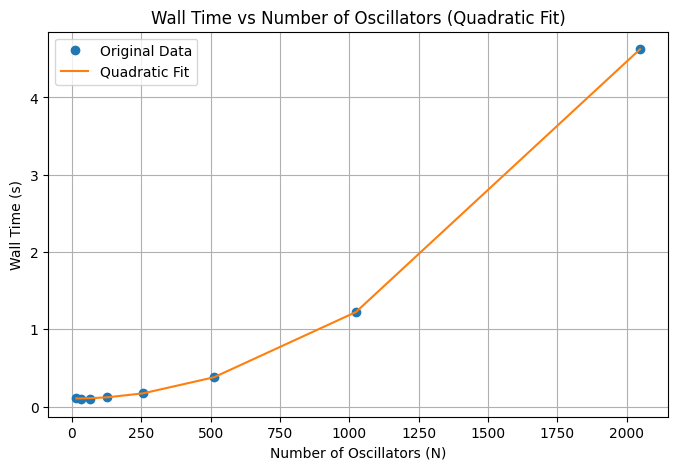

Quadratic Coefficients: [ 1.08830147e-06 -2.24785801e-05  1.04534767e-01]
R-squared: 0.9999798656252215


In [47]:
coeffs = np.polyfit(N_values, wall_times, 2)
quadratic_fit = np.poly1d(coeffs)

predicted_times = quadratic_fit(N_values)

plt.figure(figsize=(8, 5))
plt.plot(N_values, wall_times, 'o', label='Original Data')
plt.plot(N_values, predicted_times, '-', label='Quadratic Fit')
plt.xlabel('Number of Oscillators (N)')
plt.ylabel('Wall Time (s)')
plt.title('Wall Time vs Number of Oscillators (Quadratic Fit)')
plt.legend()
plt.grid()
plt.show()

# Calculate residuals
residuals = wall_times - predicted_times

# Calculate R-squared
ss_res = np.sum(residuals**2) 
ss_tot = np.sum((wall_times - np.mean(wall_times))**2) 
r_squared = 1 - (ss_res / ss_tot)

print("Quadratic Coefficients:", coeffs)
print("R-squared:", r_squared)

### Code Calculation for Percentage Errors at certain durations

In [6]:
import numpy as np
step_sizes = [1, 4, 16, 64]  # in ms
durations = [100, 1000, 10000]  # in ms
N_values = [128, 256, 512]  # different numbers of oscillators
baseline_results = None  # Store baseline results for 1 ms step size

for N in N_values:
    for step_size in step_sizes:
        defaultclock.dt = step_size * ms
        # Run simulation for the specified durations
        results = []
        for duration in durations:
            z_values = run_sim(N, K, F, Delta, p1, p2, omega_0, tau, sigma, duration*ms)
            results.append(z_values[-1])
        
        if step_size == 1:  # Store baseline for 1 ms step size
            baseline_results = results
        
        # Compare results to baseline and calculate relative errors
        relative_errors = []
        for i, duration in enumerate(durations):
            relative_error = np.abs(results[i] - baseline_results[i]) / np.abs(baseline_results[i]) * 100
            rounded_relative_error = round(relative_error, 1)
            relative_errors.append(rounded_relative_error)
        
        # Print or save relative errors for analysis
        formatted_errors = ", ".join([f"{x:.1f}%" for x in relative_errors])
        print(f"Step size: {step_size} ms, N: {N}, Relative Errors: [{formatted_errors}]")





Step size: 1 ms, N: 128, Relative Errors: [0.0%, 0.0%, 0.0%]
Step size: 1 ms, N: 128, Accumulated Error: 0.000
Step size: 4 ms, N: 128, Relative Errors: [0.6%, 0.9%, 0.0%]
Step size: 4 ms, N: 128, Accumulated Error: 1.498
Step size: 16 ms, N: 128, Relative Errors: [1.6%, 3.3%, 0.2%]
Step size: 16 ms, N: 128, Accumulated Error: 5.038
Step size: 64 ms, N: 128, Relative Errors: [8.6%, 14.9%, 0.3%]
Step size: 64 ms, N: 128, Accumulated Error: 23.791
Step size: 1 ms, N: 256, Relative Errors: [0.0%, 0.0%, 0.0%]
Step size: 1 ms, N: 256, Accumulated Error: 0.000
Step size: 4 ms, N: 256, Relative Errors: [1.2%, 0.5%, 0.8%]
Step size: 4 ms, N: 256, Accumulated Error: 2.412
Step size: 16 ms, N: 256, Relative Errors: [1.9%, 2.3%, 0.6%]
Step size: 16 ms, N: 256, Accumulated Error: 4.790
Step size: 64 ms, N: 256, Relative Errors: [8.8%, 14.1%, 0.7%]
Step size: 64 ms, N: 256, Accumulated Error: 23.612
Step size: 1 ms, N: 512, Relative Errors: [0.0%, 0.0%, 0.0%]
Step size: 1 ms, N: 512, Accumulated Er

### Code Calculation for Total Accumulated Error and Total Accumulated Percentage Error up until a certain time point.

In [21]:
new_step_sizes = [4,16,32, 64]
total_time = 1000
for N in N_values:
    defaultclock.dt = 1 * ms
    baseline_results = run_sim(N, K, F, Delta, p1, p2, omega_0, tau, sigma, total_time*ms)
    for step_size in new_step_sizes:
        defaultclock.dt = step_size * ms
        results = run_sim(N, K, F, Delta, p1, p2, omega_0, tau, sigma, total_time*ms)
        accumulated_error = 0
        accumulated_percentage_error = 0
        #Calculate errors for each value in results with its corresponding value in baseline_results
        for i, value in enumerate(results):
            error = np.abs(value - baseline_results[i*step_size])
            percentage_error = np.abs(results[i] - baseline_results[i]) / np.abs(baseline_results[i]) * 100
            accumulated_error += error
            accumulated_percentage_error += percentage_error
        #Average out all errors depending on step_size
        accumulated_error *= step_size
        accumulated_percentage_error *= step_size
        print(f"Step size: {step_size} ms, N: {N}, Accumulated Error up to {total_time} ms: {accumulated_error:.3f}; Accumulated Percentage Error: {accumulated_percentage_error:.3f}")

Step size: 4 ms, N: 128, Accumulated Error up to 1000 ms: 0.511; Accumulated Percentage Error: 42494.085
Step size: 16 ms, N: 128, Accumulated Error up to 1000 ms: 2.518; Accumulated Percentage Error: 49994.484
Step size: 32 ms, N: 128, Accumulated Error up to 1000 ms: 4.436; Accumulated Percentage Error: 49971.888
Step size: 64 ms, N: 128, Accumulated Error up to 1000 ms: 8.845; Accumulated Percentage Error: 45434.427
Step size: 4 ms, N: 256, Accumulated Error up to 1000 ms: 7.148; Accumulated Percentage Error: 39991.118
Step size: 16 ms, N: 256, Accumulated Error up to 1000 ms: 3.392; Accumulated Percentage Error: 47538.153
Step size: 32 ms, N: 256, Accumulated Error up to 1000 ms: 5.339; Accumulated Percentage Error: 47525.031
Step size: 64 ms, N: 256, Accumulated Error up to 1000 ms: 11.145; Accumulated Percentage Error: 43316.610
Step size: 4 ms, N: 512, Accumulated Error up to 1000 ms: 3.585; Accumulated Percentage Error: 36179.972
Step size: 16 ms, N: 512, Accumulated Error up t